In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from tensorflow.keras import layers
import joblib
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Pickle caused memory errors for both Colab and Jupyter in HRPC Resources, I used joblib instead to extract tensors from file.

In [3]:
train_images = joblib.load("/content/drive/MyDrive/train_images")
train_labels = joblib.load("/content/drive/MyDrive/train_labels")

The next part is divided between Colab and HRPC resources that use different tensorflow versions. They convert the tensors to a numpy array and reshape them to shape (60000, 28, 28, 1) and (60000,) to use with the NN.

FOR COLAB (VERSION TENSORFLOW >= 2), UNCOMMENT CELL BELOW

In [4]:
train_images = train_images.numpy()
train_labels = train_labels.numpy()
train_images = train_images.reshape((60000, 28, 28, 1))

FOR VERSION TENSORFLOW < 2, USE CELL BELOW

In [ ]:
# train_images = tf.Session().run(tf.reshape(train_images, (60000, 28, 28, 1)))
# train_labels = tf.Session().run(tf.reshape(train_labels, (60000,)))

Convert images to 0 - 1 pixel values by converting array to float32 and dividing by 255.

In [6]:
train_images = train_images.astype("float32") / 255

TRAIN ON SCRATCH-MADE SMALL CONVOLUTIONAL NEURAL NETWORK.
We use 2 pooling layers across 3 convolution layers. As discussed in the book, we increase from 32 filters to 2 64 filters using relu activation. We then flatten the model use two dense fully connected layers of size 100 and then 10 for the 10 classifiers (using softmax).

In [14]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Flatten()(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                       

We use rmsprop optimtization and sparse_categorical_crossentropy because we aren't doing a sigmoid/binary problem. We train for 15 epochs (10 isn't enough and 20 leads to an increase of validation loss after a local minimum). Changing batch size has very little effect on validation accuracy, so we choose a batch size of 128 which gives us faster training.

In [15]:
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="MihirChadaga636Project.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(train_images, train_labels, validation_split = 0.2, epochs=15, batch_size=128, callbacks=callbacks)

Epoch 1/15
375/375 [==============================] - 4s 7ms/step - loss: 2.0774 - accuracy: 0.2432 - val_loss: 1.8734 - val_accuracy: 0.3456
Epoch 2/15
375/375 [==============================] - 2s 6ms/step - loss: 1.6956 - accuracy: 0.4093 - val_loss: 1.5169 - val_accuracy: 0.4748
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 1.4056 - accuracy: 0.5175 - val_loss: 1.3138 - val_accuracy: 0.5491
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 1.2713 - accuracy: 0.5653 - val_loss: 1.2002 - val_accuracy: 0.5906
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 1.1845 - accuracy: 0.5936 - val_loss: 1.1566 - val_accuracy: 0.6043
Epoch 6/15
375/375 [==============================] - 2s 5ms/step - loss: 1.1236 - accuracy: 0.6144 - val_loss: 1.0907 - val_accuracy: 0.6280
Epoch 7/15
375/375 [==============================] - 2s 5ms/step - loss: 1.0827 - accuracy: 0.6303 - val_loss: 1.0709 - val_accuracy: 0.6357
Epoch 

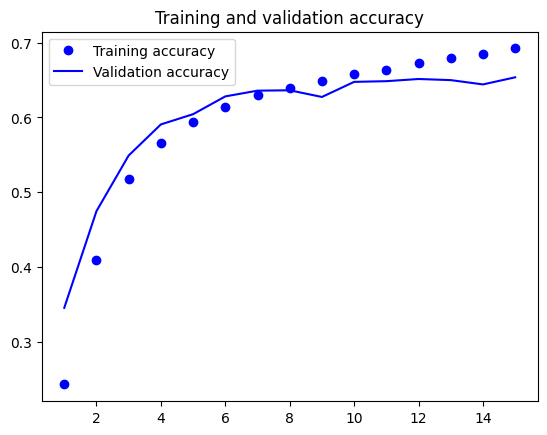

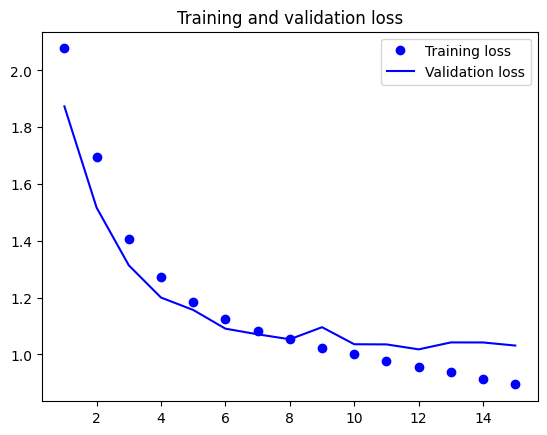

In [16]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [33]:
import sklearn.model_selection
train_i, test_images, train_l, test_labels = sklearn.model_selection.train_test_split(train_images, train_labels, test_size=0.2)
test_model = keras.models.load_model("MihirChadaga636Project.keras")
test_loss, test_acc = test_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

375/375 [==============================] - 1s 2ms/step - loss: 0.9090 - accuracy: 0.6894
Test accuracy: 0.689
